In [26]:
import numpy as np
import matplotlib.pyplot as plt
import sigmf
from sigmf import sigmffile, SigMFFile

## Load the dataset


In [27]:
filename = 'data/dataset'
sigFile = sigmffile.fromfile(filename, skip_checksum=True)
annotations = sigFile.get_annotations()
nSignals = len(annotations)
# TODO: For now, I'm assuming all the data has the same length
nSamps = int(sigFile.sample_count/nSignals)
# The input data is a tensor with shape nSignals x 2 x nSamps
x = np.zeros((nSignals, 2, nSamps))
labels = np.array(['']*nSignals, dtype=object)
for iSignal, annotation in enumerate(annotations):
    # Label of the current signal
    labels[iSignal] = annotation[SigMFFile.LABEL_KEY]
    # Start index of the current signal
    annotationStart = annotation[SigMFFile.START_INDEX_KEY]
    # Length of the current signal in samples
    annotationLength = annotation[SigMFFile.LENGTH_INDEX_KEY]
    # Data for the current signal
    samples = sigFile.read_samples(annotationStart, annotationLength)
    # Store the signal data in the input tensor
    # Note: Since the data is complex, we need to split it into real and imaginary
    # parts because neural networks have trouble handling complex data
    x[iSignal, 0, :] = np.real(samples)
    x[iSignal, 1, :] = np.imag(samples)
# Number of unique signal classes
classes = np.unique(labels)


## Partition the data into training and testing sets


In [28]:
np.random.seed(0)
nTrain = int(0.5*nSignals)
nTest = nSignals - nTrain
# Since the input data is heavily structured, we need to shuffle the data to
# form the training and testing sets
trainIndex = np.random.permutation(range(0, nSignals))[0:nTrain]
# The test set is the complement of the training set
testIndex = list(set(range(0, nSignals)) - set(trainIndex))
# Generate the train/test examples/labels
xTrain = x[trainIndex, :, :]
xTest = x[testIndex, :, :]
labelTrain = labels[trainIndex]
labelTest = labels[testIndex]
inputShape = list(xTrain.shape[1:])
print(xTrain.shape)

(10000, 2, 128)


## Convert the class labels to one-hot vectors


In [29]:
def onehot(array):
  """
  Convert a list of labels to onehot representation
  """
  # Get the array of unique labels and the indices of the unique array that can
  # be used to reconstruct array
  unique, inverse = np.unique(array,return_inverse=True)
  # Each row of this identity matrix is the one-hot representation of each label
  # in unique, so we can get the one-hot encoding by choosing the corresponding
  # row for each index in inverse
  oh = np.eye(unique.shape[0])[inverse]
  return oh
yTrain = onehot(labelTrain)
yTest = onehot(labelTest)

## Build the model using Tensorflow


In [30]:
# CNN imports
# TODO: Move these to the top of the file
import os
import tensorflow as tf
from tensorflow.keras.layers import Reshape, ZeroPadding2D, Conv2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras import Sequential
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# Build the model
#   - Reshape the [N,2,128] input to [N,1,2,128]
dropoutRate = 0.5
model = Sequential()
model.add(Reshape(inputShape+[1],
                  input_shape=inputShape))
model.add(ZeroPadding2D((2,0),
                        data_format='channels_first'))
model.add(Conv2D(256, (1, 3),
                 activation='relu',
                 padding='valid',
                 name='conv1'))
model.add(Dropout(dropoutRate))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(80, (2, 3),
                 padding='valid',
                 activation='relu',
                 name='conv2'))
model.add(Dropout(dropoutRate))
model.add(Flatten())
model.add(Dense(256,
                activation='relu', kernel_initializer='he_normal', name='dense1'))
model.add(Dropout(dropoutRate))
model.add(Dense(len(classes),
                kernel_initializer='he_normal', name='dense2'))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='Adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_10 (Reshape)        (None, 2, 128, 1)         0         
                                                                 
 zero_padding2d_10 (ZeroPadd  (None, 2, 132, 1)        0         
 ing2D)                                                          
                                                                 
 conv1 (Conv2D)              (None, 2, 130, 256)       1024      
                                                                 
 dropout_15 (Dropout)        (None, 2, 130, 256)       0         
                                                                 
 zero_padding2d_11 (ZeroPadd  (None, 2, 134, 256)      0         
 ing2D)                                                          
                                                                 
 conv2 (Conv2D)              (None, 1, 132, 80)       

## Train the model

In [31]:
nEpochs = 10
batchSize = 1024
history = model.fit(xTrain,yTrain,
                    batch_size=batchSize,
                    epochs=nEpochs,
                    validation_data=(xTest,yTest),
                    verbose=2,
                    callbacks = [
                      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto'),
                    ])

Epoch 1/10
10/10 - 12s - loss: 0.6843 - val_loss: 0.6435 - 12s/epoch - 1s/step
Epoch 2/10
10/10 - 12s - loss: 0.5201 - val_loss: 0.2585 - 12s/epoch - 1s/step
Epoch 3/10
10/10 - 12s - loss: 0.1193 - val_loss: 0.0095 - 12s/epoch - 1s/step
Epoch 4/10
10/10 - 12s - loss: 0.0047 - val_loss: 2.0189e-04 - 12s/epoch - 1s/step
Epoch 5/10
10/10 - 12s - loss: 2.6166e-04 - val_loss: 2.9188e-05 - 12s/epoch - 1s/step
Epoch 6/10
10/10 - 12s - loss: 7.3280e-05 - val_loss: 1.2362e-05 - 12s/epoch - 1s/step
Epoch 7/10
10/10 - 12s - loss: 4.2904e-05 - val_loss: 8.2803e-06 - 12s/epoch - 1s/step
Epoch 8/10
10/10 - 12s - loss: 3.4880e-05 - val_loss: 6.3847e-06 - 12s/epoch - 1s/step
Epoch 9/10
10/10 - 13s - loss: 2.7202e-05 - val_loss: 5.5375e-06 - 13s/epoch - 1s/step
Epoch 10/10
10/10 - 12s - loss: 2.5177e-05 - val_loss: 5.0949e-06 - 12s/epoch - 1s/step


5.0949111027875915e-06


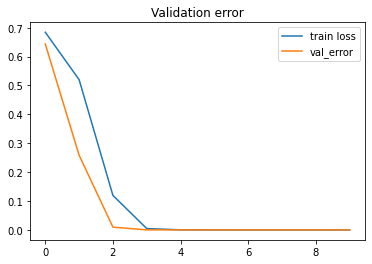

In [33]:
score = model.evaluate(xTest, yTest, verbose=0,batch_size=batchSize)
print(score)
# Show loss curves 
plt.figure()
plt.title('Validation error')
plt.plot(history.epoch, history.history['loss'], label='train loss')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()